In [25]:
# %pip install opencv-python

from board import Tile, Board
import cv2
import numpy as np

import matplotlib.pyplot as plt

In [26]:
class Line:
    """
    Store a line based on the two points.
    """
    def __init__(self, point_1, point_2):
        self.point_1 = point_1
        self.point_2 = point_2
        

class Point:
    def __init__(self, x, y):
        self.x = np.int32(np.round(x))
        self.y = np.int32(np.round(y))
    
    def get_point_as_tuple(self):
        return (self.x, self.y)
    

In [38]:
def align_board(template_path: str, query_path: str, output_size=(800,800)):
    template = cv2.imread(template_path)
    query    = cv2.imread(query_path)
    tpl_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    qry_gray = cv2.cvtColor(query,   cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(tpl_gray, None)
    kp2, des2 = sift.detectAndCompute(qry_gray, None)
    
    # FLANN parameters
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)  # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    raw_matches = flann.knnMatch(des1, des2, k=2)
    matches = []
    # Need to draw only good matches, so create a mask
    for m, n in raw_matches:
        if m.distance < 0.7 * n.distance:
            matches.append(m)
    
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    h, w = template.shape[:2]
    aligned = cv2.warpPerspective(query, M, (w, h))
    aligned = cv2.resize(aligned, output_size)
    
    return template, query, aligned

In [35]:
def detect_board_and_warp(image_path, output_size=(800, 800)):
    # Load and resize image (optional)
    img = cv2.imread(image_path)
    # img = cv2.resize(img, (1000, 1000))  # scale for consistency
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #plot grayscaled image
    plt.imshow(gray, cmap='gray')
    plt.axis('off')
    plt.show()
    
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=150, minLineLength=300, maxLineGap=20)
    
    debug_lines = img.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(debug_lines, (x1, y1), (x2, y2), (255, 0, 0), 5)
            
    # Approximate outer rectangle from Hough lines (very naive)
    # We assume that the outermost lines (bounding the board) are the longest horizontal/vertical
    verticals = []
    horizontals = []
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(x1 - x2) < 20:  # vertical line
            verticals.append(line[0])
        elif abs(y1 - y2) < 20:  # horizontal line
            horizontals.append(line[0])
            
    top = min(horizontals, key=lambda l: l[1])
    bottom = max(horizontals, key=lambda l: l[1])
    left = min(verticals, key=lambda l: l[0])
    right = max(verticals, key=lambda l: l[0])
    
    src_pts = np.array([
        [left[0], top[1]],
        [right[2], top[1]],
        [right[2], bottom[3]],
        [left[0], bottom[3]]
    ], dtype='float32')

    dst_pts = np.array([
        [0, 0],
        [output_size[0] - 1, 0],
        [output_size[0] - 1, output_size[1] - 1],
        [0, output_size[1] - 1]
    ], dtype='float32')

    # Perspective warp
    matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, matrix, output_size)

    return img, debug_lines, warped

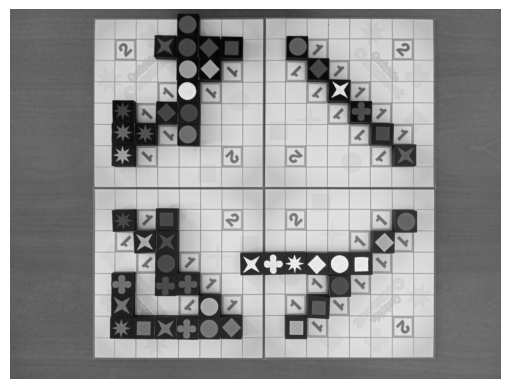

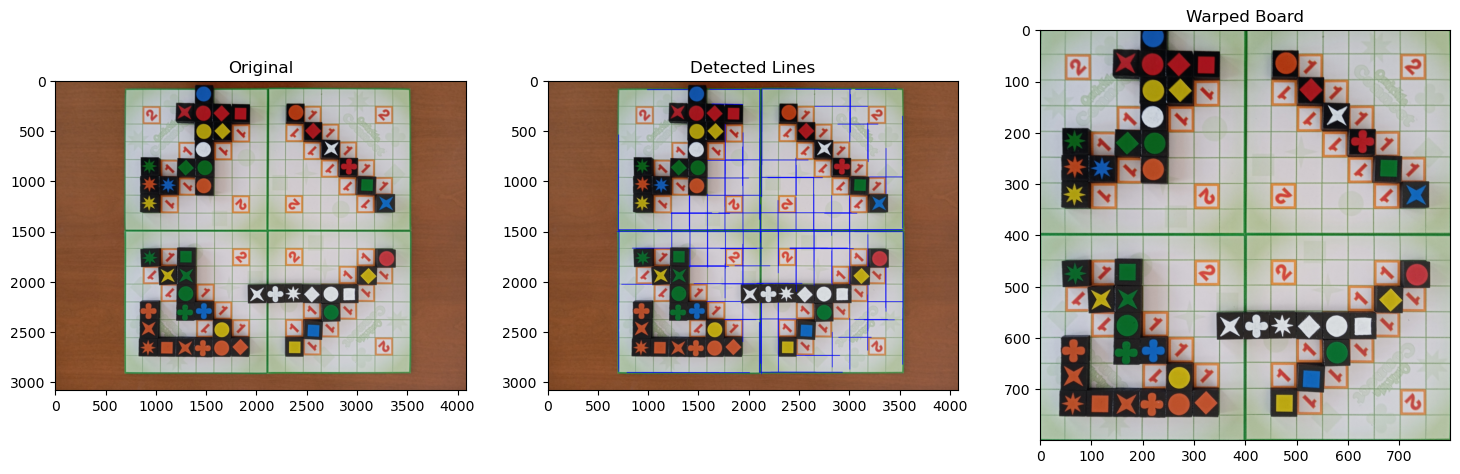

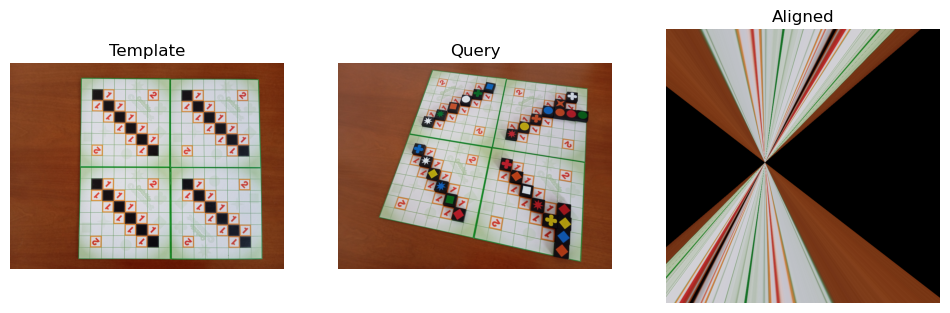

In [43]:
input_img = 'train/1_08.jpg'
original, lines, warped = detect_board_and_warp(input_img)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.title("Detected Lines")
plt.imshow(cv2.cvtColor(lines, cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.title("Warped Board")
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

tpl, qry, aligned = align_board(
    "board+tiles/board_2.jpg",    # your clean top-down board image
    "train/2_02.jpg",     # your skewed capture
    output_size=(800,800)
)

plt.figure(figsize=(12,4))
for i, img in enumerate([tpl, qry, aligned], 1):
    plt.subplot(1,3,i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(["Template","Query","Aligned"][i-1])
plt.show()